In [19]:
import random
import torch
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from datetime import datetime
import os
import time

from scipy.stats import norm, skewnorm, gamma

In [10]:
seed = 633

print("[ Using Seed : ", seed, " ]")

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
numpy.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

[ Using Seed :  633  ]


In [11]:
from koopman_probabilistic import KoopmanProb
from model_objs import GammaNLL

In [30]:
station_name = 'Station0004436'

station_path = ".\\atmo_chem\\seattle\\" + station_name
obsfile = os.path.join(station_path, 'obs_%s.csv'.replace('%s',station_name))
obs = pd.read_csv(obsfile, parse_dates=['ISO8601','localtime'], date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601'])
obs["t"] = [time.mktime(obs.ISO8601.iloc[i].timetuple()) for i in range(len(obs))]
obs_no2 = obs.loc[obs.obstype=='no2']
 
modfile = os.path.join(station_path, 'model_forecast_%s.csv'.replace('%s',station_name))
mod = pd.read_csv(modfile, parse_dates=['ISO8601','ISO8601_init'],date_parser=lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%SZ')).sort_values(by=['ISO8601_init','ISO8601'])
mod["t"] = [time.mktime(mod.ISO8601.iloc[i].timetuple()) for i in range(len(mod))]


In [31]:
obs_no2

,ISO8601,localtime,location,original_station_name,lat,lon,obstype,conc_mod,conc_obs,conc_unit,t
1,2018-01-01 02:00:00,2017-12-31 18:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,31.6068,9.0,ppbv,1.514801e+09
4,2018-01-01 12:00:00,2018-01-01 04:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.9303,13.0,ppbv,1.514837e+09
7,2018-01-01 14:00:00,2018-01-01 06:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,12.0199,15.0,ppbv,1.514844e+09
9,2018-01-01 17:00:00,2018-01-01 09:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.3669,7.0,ppbv,1.514855e+09
14,2018-01-01 20:00:00,2018-01-01 12:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.4251,8.0,ppbv,1.514866e+09
...,...,...,...,...,...,...,...,...,...,...,...
65994,2021-03-14 16:00:00,2021-03-14 08:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.5915,15.0,ppbv,1.615763e+09
65997,2021-03-14 17:00:00,2021-03-14 09:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.8866,18.0,ppbv,1.615766e+09
66000,2021-03-14 18:00:00,2021-03-14 10:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.4541,13.0,ppbv,1.615770e+09
66003,2021-03-14 19:00:00,2021-03-14 11:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.2423,15.0,ppbv,1.615774e+09


In [79]:
mod[100:150]

,ISO8601_init,ISO8601,location,lat,lon,NO2,O3,PM25_RH35_GCC,t
100,2019-01-01,2019-01-05 16:30:00,Station0004436,47.5682,-122.3086,1.609444e-08,1.647277e-08,20.309013,1.546735e+09
101,2019-01-01,2019-01-05 17:30:00,Station0004436,47.5682,-122.3086,1.568698e-08,1.685112e-08,20.014616,1.546738e+09
102,2019-01-01,2019-01-05 18:30:00,Station0004436,47.5682,-122.3086,1.495939e-08,1.804437e-08,18.951313,1.546742e+09
103,2019-01-01,2019-01-05 19:30:00,Station0004436,47.5682,-122.3086,1.446462e-08,1.877197e-08,18.445723,1.546745e+09
104,2019-01-01,2019-01-05 20:30:00,Station0004436,47.5682,-122.3086,1.418814e-08,1.920853e-08,18.378477,1.546749e+09
105,2019-01-01,2019-01-05 21:30:00,Station0004436,47.5682,-122.3086,1.410083e-08,1.947046e-08,18.343416,1.546753e+09
106,2019-01-01,2019-01-05 22:30:00,Station0004436,47.5682,-122.3086,1.516312e-08,1.833541e-08,19.090786,1.546756e+09
107,2019-01-01,2019-01-05 23:30:00,Station0004436,47.5682,-122.3086,1.769515e-08,1.519220e-08,21.151457,1.546760e+09
108,2019-01-01,2019-01-06 00:30:00,Station0004436,47.5682,-122.3086,2.092569e-08,1.148146e-08,23.712910,1.546763e+09
109,2019-01-01,2019-01-06 01:30:00,Station0004436,47.5682,-122.3086,2.243909e-08,9.749783e-09,26.181316,1.546767e+09


In [77]:
diff = -(pd.to_datetime(mod.ISO8601_init) - pd.to_datetime(mod.ISO8601))
five_day_mod = mod[(diff > dt.timedelta(days=4)) & (diff < dt.timedelta(days=5))]

<IPython.core.display.Javascript object>


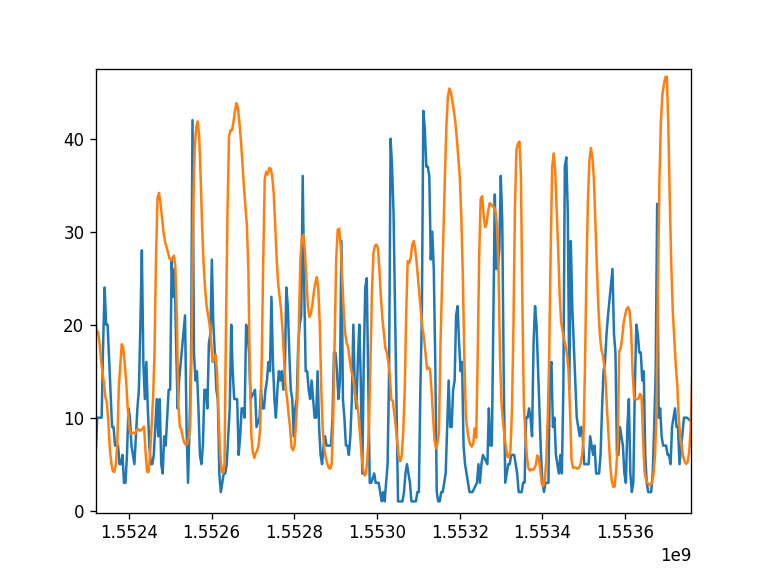

In [78]:
%matplotlib notebook
plt.plot(obs_no2.t, obs_no2.conc_obs)
plt.plot(five_day_mod.t, five_day_mod.NO2 * 1e9)

In [26]:
obs_no2

,ISO8601,localtime,location,original_station_name,lat,lon,obstype,conc_mod,conc_obs,conc_unit
1,2018-01-01 02:00:00,2017-12-31 18:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,31.6068,9.0,ppbv
4,2018-01-01 12:00:00,2018-01-01 04:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.9303,13.0,ppbv
7,2018-01-01 14:00:00,2018-01-01 06:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,12.0199,15.0,ppbv
9,2018-01-01 17:00:00,2018-01-01 09:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.3669,7.0,ppbv
14,2018-01-01 20:00:00,2018-01-01 12:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.4251,8.0,ppbv
...,...,...,...,...,...,...,...,...,...,...
65994,2021-03-14 16:00:00,2021-03-14 08:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.5915,15.0,ppbv
65997,2021-03-14 17:00:00,2021-03-14 09:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,14.8866,18.0,ppbv
66000,2021-03-14 18:00:00,2021-03-14 10:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,15.4541,13.0,ppbv
66003,2021-03-14 19:00:00,2021-03-14 11:00:00,Station0004436,Seattle-BeaconHill,47.5682,-122.3086,no2,13.2423,15.0,ppbv


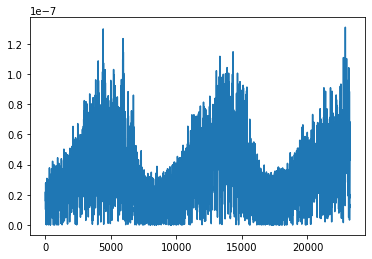

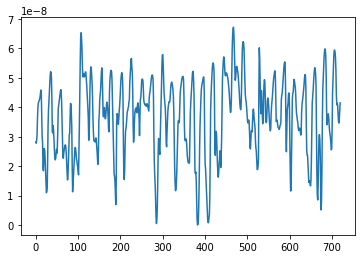

O3 





In [30]:
%matplotlib inline
for col in all_data.columns[16:17]:
    plt.plot(all_data[col].values)
    plt.show()
    plt.plot(all_data[col].iloc[2000:2720].values)
    plt.show()
    print(col, "\n\n\n")

In [9]:
# for flu data/integer data, use smooth parameter, discrete probability dist
# NO2, O3, NO, HNO4, ISOP, N2O5, NIT, PRPE, SOAP
# EMIS --all of them have very strong daily, weekly, and annual patterns
# EMIS_ISOP (cleaner version of NO)
%matplotlib notebook
# plt.plot(all_data.time, all_data.NO)

In [23]:
chemical = "O3"
x = np.expand_dims(all_data[chemical].values, -1)

In [24]:
null_idx = np.isnan(x).nonzero()[0]
print(null_idx)
x[null_idx] = (x[null_idx - 1] + x[null_idx + 1]) / 2

[]


In [25]:
x_original = x
rnge = np.max(x, axis=0) - np.min(x, axis=0)
x = x / np.tile(rnge, (x.shape[0], 1))
print("x", x.shape)

x (23232, 1)


In [26]:
plt.plot(x)

In [27]:
data_name = chemical

train_through = 2 * 365 * 24
train_start = 0
delay = 0  # 52 * 24  # 1.5 to 2 month gap, then 1 month forecast
x = x[train_start:]
predict_through = train_through + 24 * 365 * 8 // 12 + delay  
x = x[:predict_through]
xt = x[:train_through]

num_freqs = [2, 2]
num_fourier = 2
now = ("_".join(str(datetime.now()).split())).replace(":", ".")
rate_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}rate.npy"
a_file = "atmo_chem//" + data_name + now + f"trained{train_start}-{train_through}_{num_freqs}a.npy"
print("x", x.shape)
print("xt", xt.shape)

x (23232, 1)
xt (17520, 1)


In [15]:
model = GammaNLL(x_dim=xt.shape[1], num_freqs=num_freqs, n=256)
k = KoopmanProb(model, device='cpu', sample_num=24, num_fourier_modes=num_fourier, batch_size=32)

In [16]:
k.find_fourier_omegas(xt, hard_code=[24, 24 * 365.25])  # Day, Year
# k.find_fourier_omegas(xt, hard_code=[24, 168, 365.25 * 24 / 12, 24 * 365.25])  # Day, Week, Month, Year

tensor([0.2618, 0.0007])

In [17]:
k.fit(xt, iterations=300, interval=10, verbose=True, cutoff=0, weight_decay=1e-3, lr_theta=1e-4, lr_omega=0);

Iteration  0
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.17481185
Iteration  1
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.20172474
Iteration  2
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.22437361
Iteration  3
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.24533673
Iteration  4
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.26484695
Iteration  5
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.28362995
Iteration  6
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], 

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.69807076
Iteration  56
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.699088
Iteration  57
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.70005983
Iteration  58
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7006199
Iteration  59
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7020181
Iteration  60
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.70259154
Iteration  61
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.703281
Iterati

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.732917
Iteration  111
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7336336
Iteration  112
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7343366
Iteration  113
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.73474544
Iteration  114
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7355541
Iteration  115
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.736025
Iteration  116
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7363381
Ite

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7652501
Iteration  166
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7656557
Iteration  167
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7664389
Iteration  168
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76701707
Iteration  169
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76719093
Iteration  170
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.76796585
Iteration  171
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7687272

Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.78948265
Iteration  221
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.789717
Iteration  222
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.78979576
Iteration  223
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7903034
Iteration  224
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7911892
Iteration  225
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.7910965
Iteration  226
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.79124016


Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8018447
Iteration  276
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80192554
Iteration  277
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8021247
Iteration  278
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80201614
Iteration  279
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.80220336
Iteration  280
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8024061
Iteration  281
tensor([  24., 8766.,   24., 8766.])
Setting periods to tensor([  24., 8766.,   24., 8766.], grad_fn=<MulBackward0>)
Loss:  -0.8024289

In [28]:
params = k.predict(predict_through)
rate_hat, a_hat = params
np.save(rate_file, rate_hat)
np.save(a_file, a_hat)

## Get Quantiles

In [33]:
def gamma_quantiles(rate, a, quantiles):
    T = len(rate)
    quant_preds = np.zeros((T, len(quantiles)))
    for t in range(T):
        rv = gamma(a[t], scale=1/rate[t])
        for j, q in enumerate(quantiles):
            quant_preds[t, j] = rv.ppf(q)
    return quant_preds

In [34]:
quantiles = np.array([30, 60, 85, 98], dtype=np.float32) / 100
quant_preds = gamma_quantiles(rate_hat, a_hat, quantiles=quantiles)

<IPython.core.display.Javascript object>


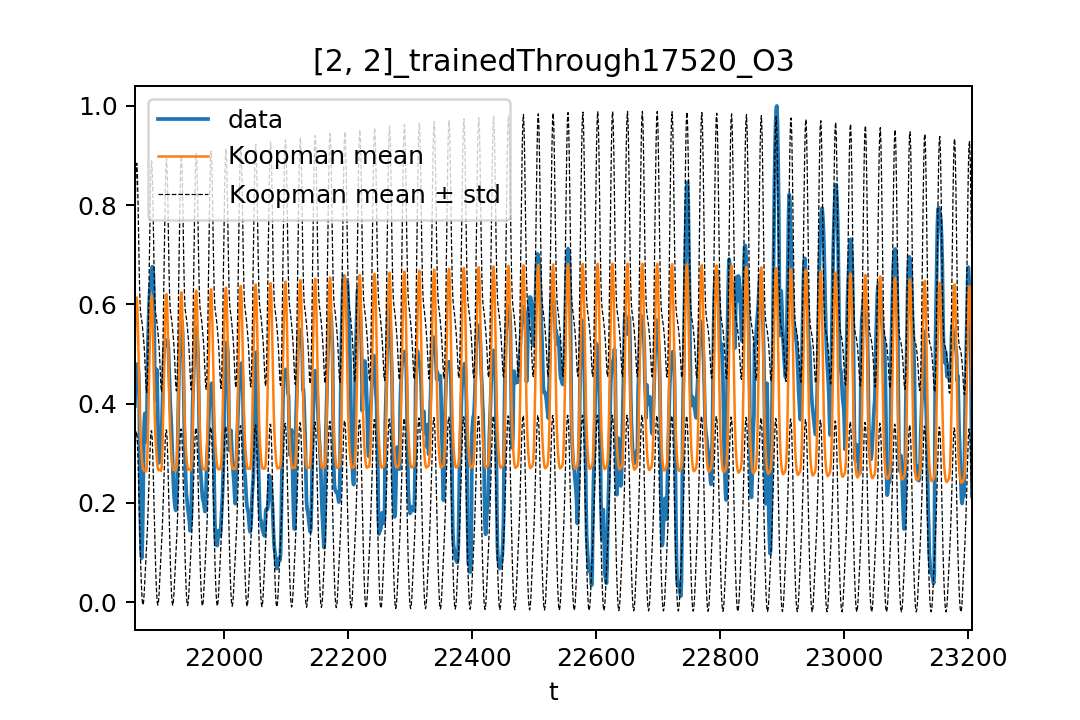

In [33]:
%matplotlib notebook

mean_hat = model.mean(params)
std_hat = model.std(params)
for dim in range(xt.shape[1]):
    plt.figure(dpi=150)
    plt.plot(x[:predict_through, dim], label="data")
#     colors = [(i / len(quantiles), 0, 0) for i in range(len(quantiles))]
#     for j in range(0, len(quantiles), 1):
#         plt.plot(quant_preds[:, j], color=colors[j], linewidth=0.05, label=quantiles[j])
        
    plt.plot(mean_hat[:, dim], label="Koopman mean", linewidth=1)
    plt.plot(mean_hat[:, dim] + std_hat[:, dim], "--", color="black", label="Koopman mean $\pm$ std", linewidth=0.5)
    plt.plot(mean_hat[:, dim] - std_hat[:, dim], "--", color="black", linewidth=0.5)

    plt.title(f"{num_freqs}_trainedThrough{train_through}_" + data_name)
    plt.xlabel("t")
    plt.legend()
    plt.show()

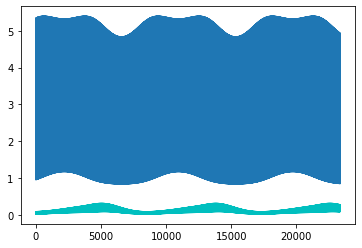

In [34]:
%matplotlib inline
plt.plot(a_hat)
plt.plot(1/rate_hat, color="c")

In [35]:
print("actual overall mean:", np.mean(xt), " predicted mean:", np.mean(mean_hat[:train_through]))

actual overall mean: 0.25223155380058526  predicted mean: 0.251418


In [38]:
a = 3
scale = 0.03
lins = np.linspace(1e-4, 1, 100)
gampdf = gamma.pdf(lins, a, scale=scale)

<IPython.core.display.Javascript object>


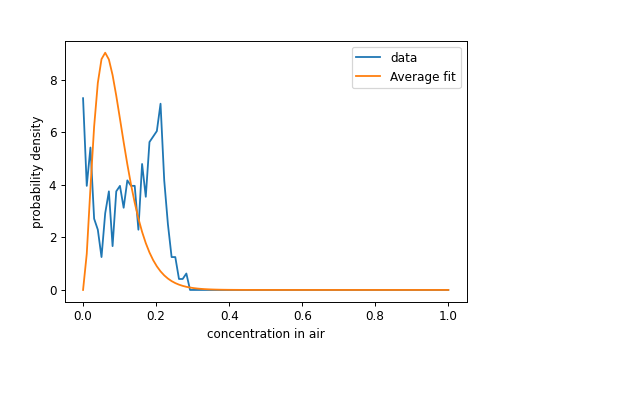

In [40]:
%matplotlib notebook
plt.figure()
hist, bin_edges = np.histogram(x[:24 * 20, 0], bins=100, range=(0, 1), density=True)
plt.plot(lins, hist, label="data")
plt.plot(lins, gampdf, label="Average fit")

plt.xlabel("concentration in air")
plt.ylabel("probability density")
plt.legend()
# plt.semilogx()
# plt.semilogy()
plt.show()

In [45]:
"mean of a_hat", np.mean(a_hat), "std of a_hat", np.std(a_hat)

('mean of a_hat', 1.8193762, 'std of a_hat', 0.5413571)